In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re
from difflib import SequenceMatcher

def similarity(a, b):
    """Calculate similarity between two strings"""
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def normalize_model_name(name):
    """Normalize model names for better matching"""
    if pd.isna(name):
        return ""
    # Convert to string and lowercase
    name = str(name).lower().strip()
    # Remove common suffixes/prefixes that might vary
    name = re.sub(r'\s*\([^)]*\)', '', name)  # Remove parentheses content
    name = re.sub(r'\s+', ' ', name)  # Normalize whitespace
    return name.strip()

# Read the datasets
print("Reading datasets...")
historical_df = pd.read_csv('datasets/historical_price.csv')
benchmark_df = pd.read_csv('art_analysis_inf_data.csv')

# Clean historical data - remove rows where Model is NaN
historical_df = historical_df.dropna(subset=['Model'])

print(f"Historical price data: {historical_df.shape[0]} rows")
print(f"Benchmark data: {benchmark_df.shape[0]} rows")

# Find MMLU-Pro column
mmlu_col = 'MMLU-Pro (Reasoning & Knowledge)'
print(f"Using MMLU-Pro column: {mmlu_col}")

# Clean benchmark data - remove rows where MMLU-Pro is NaN
benchmark_df = benchmark_df.dropna(subset=[mmlu_col])
print(f"Benchmark data after cleaning: {benchmark_df.shape[0]} rows")

# Convert MMLU-Pro percentages to numeric (remove % if present)
benchmark_df[mmlu_col] = benchmark_df[mmlu_col].astype(str).str.replace('%', '').astype(float)

print(f"MMLU-Pro score range: {benchmark_df[mmlu_col].min():.3f} to {benchmark_df[mmlu_col].max():.3f}")
print(f"Sample MMLU-Pro values: {benchmark_df[mmlu_col].head().tolist()}")


Reading datasets...
Historical price data: 873 rows
Benchmark data: 250 rows
Using MMLU-Pro column: MMLU-Pro (Reasoning & Knowledge)
Benchmark data after cleaning: 209 rows
MMLU-Pro score range: 10.000 to 87.300
Sample MMLU-Pro values: [85.1, 83.3, 68.3, 78.8, 77.2]


In [33]:
# Merge datasets on model names
print("\n=== Merging datasets ===")

# First try exact matching
merged_exact = pd.merge(historical_df, benchmark_df, on='Model', how='inner')
print(f"Exact matches: {len(merged_exact)} rows")

# For fuzzy matching, let's find the best matches
historical_models = historical_df['Model'].unique()
benchmark_models = benchmark_df['Model'].unique()

print(f"Unique models in historical data: {len(historical_models)}")
print(f"Unique models in benchmark data: {len(benchmark_models)}")

# Find fuzzy matches
threshold = 0.8  # Similarity threshold
fuzzy_matches = []

for hist_model in historical_models:
    if hist_model in benchmark_models:
        continue  # Already matched exactly
    
    best_match = None
    best_score = 0
    
    for bench_model in benchmark_models:
        score = similarity(normalize_model_name(hist_model), normalize_model_name(bench_model))
        if score > best_score and score >= threshold:
            best_score = score
            best_match = bench_model
    
    if best_match:
        fuzzy_matches.append({
            'historical': hist_model,
            'benchmark': best_match,
            'similarity': best_score
        })

print(f"Found {len(fuzzy_matches)} fuzzy matches with similarity >= {threshold}")

# Display some fuzzy matches
if fuzzy_matches:
    print("\nSample fuzzy matches:")
    for match in fuzzy_matches[:5]:
        print(f"  '{match['historical']}' -> '{match['benchmark']}' (similarity: {match['similarity']:.3f})")

# Create mapping dictionary for fuzzy matches
fuzzy_map = {match['historical']: match['benchmark'] for match in fuzzy_matches}

# Apply fuzzy matching to historical data
historical_df_mapped = historical_df.copy()
historical_df_mapped['Model_mapped'] = historical_df_mapped['Model'].map(fuzzy_map).fillna(historical_df_mapped['Model'])

# Merge with mapped names
merged_all = pd.merge(historical_df_mapped, benchmark_df, left_on='Model_mapped', right_on='Model', how='inner', suffixes=('_hist', '_bench'))

print(f"Total merged rows (exact + fuzzy): {len(merged_all)}")
print(f"Unique models in merged data: {merged_all['Model_mapped'].nunique()}")

# Display sample of merged data
print("\nSample of merged data:")
print(merged_all[['Model_hist', 'Access Date', mmlu_col, 'Blended']].head())



=== Merging datasets ===
Exact matches: 610 rows
Unique models in historical data: 299
Unique models in benchmark data: 209
Found 67 fuzzy matches with similarity >= 0.8

Sample fuzzy matches:
  'GPT-4' -> 'GPT-4o (March 2025)' (similarity: 0.909)
  'GPT-3.5 Turbo' -> 'GPT-4 Turbo' (similarity: 0.833)
  'Mistral Large' -> 'Mistral Large (Feb '24)' (similarity: 1.000)
  'Mistral Small' -> 'Mistral Small (Sep '24)' (similarity: 1.000)
  'Gemini Pro' -> 'Gemini 2.5 Pro' (similarity: 0.833)
Total merged rows (exact + fuzzy): 751
Unique models in merged data: 195

Sample of merged data:
         Model_hist Access Date  MMLU-Pro (Reasoning & Knowledge)  Blended
0             GPT-4      4/7/24                              80.0  $37.50 
1       GPT-4 Turbo      4/7/24                              69.0  $15.00 
2     GPT-3.5 Turbo      4/7/24                              69.0   $0.75 
3  Llama 2 Chat 70B      4/7/24                              41.0   $1.00 
4  Llama 2 Chat 13B      4/7/24    

In [28]:
# # Define MMLU-Pro score range and filter models
# print("\n=== Filtering by MMLU-Pro score range ===")

# # Let's first see the distribution of MMLU-Pro scores
# print(f"MMLU-Pro score statistics:")
# print(merged_all[mmlu_col].describe())

# # Define score range (you can modify these values)
# min_score = 0.7  # 70% - you can change this
# max_score = 1.0  # 100%

# print(f"\nFiltering models with MMLU-Pro scores between {min_score} and {max_score}")

# # Filter by MMLU-Pro score range
# filtered_df = merged_all[(merged_all[mmlu_col] >= min_score) & (merged_all[mmlu_col] <= max_score)]

# print(f"Models in score range: {len(filtered_df)} rows")
# print(f"Unique models in score range: {filtered_df['Model_mapped'].nunique()}")

# if len(filtered_df) > 0:
#     print(f"\nModels in the {min_score}-{max_score} MMLU-Pro range:")
#     models_in_range = filtered_df[['Model_hist', mmlu_col]].drop_duplicates().sort_values(mmlu_col, ascending=False)
#     for _, row in models_in_range.head(10).iterrows():
#         print(f"  {row['Model_hist']}: {row[mmlu_col]:.3f}")
    
#     if len(models_in_range) > 10:
#         print(f"  ... and {len(models_in_range) - 10} more models")
# else:
#     print("No models found in the specified range. Let's try a broader range...")
#     # Automatically find a better range
#     scores = merged_all[mmlu_col].sort_values(ascending=False)
#     min_score = scores.quantile(0.3)  # Top 70% of models
#     max_score = scores.max()
#     print(f"Trying broader range: {min_score:.3f} to {max_score:.3f}")
    
#     filtered_df = merged_all[(merged_all[mmlu_col] >= min_score) & (merged_all[mmlu_col] <= max_score)]
#     print(f"Models in broader range: {len(filtered_df)} rows")
#     print(f"Unique models in broader range: {filtered_df['Model_mapped'].nunique()}")


In [29]:
# # Parse dates and create TIME vs PRICE trend visualization with MMLU filtering
# print("\n=== Creating time vs price trend visualization ===")

# # Parse the Access Date column
# filtered_df = filtered_df.copy()
# filtered_df['Access Date'] = pd.to_datetime(filtered_df['Access Date'], format='%m/%d/%Y', errors='coerce')

# # Remove rows with invalid dates
# filtered_df = filtered_df.dropna(subset=['Access Date'])

# # Clean and convert Blended price column
# filtered_df['Blended'] = (
#     filtered_df['Blended']
#     .astype(str)
#     .str.replace(r'[\$,]', '', regex=True)
#     .replace('nan', np.nan)
#     .astype(float)
# )

# # Remove rows with invalid prices
# filtered_df = filtered_df.dropna(subset=['Blended'])

# print(f"Data points after date/price cleaning: {len(filtered_df)}")
# print(f"Date range: {filtered_df['Access Date'].min()} to {filtered_df['Access Date'].max()}")

# # Add license information for open source filtering
# print("\n=== Adding license information ===")
# license_col = 'License'
# filtered_df['Is_Open_Source'] = filtered_df[license_col].str.contains('Open', case=False, na=False)

# open_source_count = filtered_df['Is_Open_Source'].sum()
# total_count = len(filtered_df)
# print(f"Open source models: {open_source_count} out of {total_count} data points")

# if len(filtered_df) == 0:
#     print("No valid data points found after cleaning!")
# else:
#     def create_time_price_scatter(data, title_suffix="", open_source_only=False):
#         """Create scatter plot with time on x-axis and price on y-axis, filtered by MMLU"""
        
#         if open_source_only:
#             plot_data = data[data['Is_Open_Source']].copy()
#             title_prefix = "Open Source Models: "
#         else:
#             plot_data = data.copy()
#             title_prefix = "All Models: "
        
#         if len(plot_data) == 0:
#             print(f"No data points for {title_prefix.lower()}")
#             return
        
#         # Sort by date for better visualization
#         plot_data = plot_data.sort_values('Access Date')
        
#         # Create the scatter plot
#         fig, ax = plt.subplots(figsize=(16, 10))
        
#         # Create different markers and colors for open source vs proprietary
#         if not open_source_only:
#             # Plot proprietary models
#             proprietary_data = plot_data[~plot_data['Is_Open_Source']]
#             if len(proprietary_data) > 0:
#                 scatter1 = ax.scatter(proprietary_data['Access Date'], proprietary_data['Blended'], 
#                                     alpha=0.6, s=60, marker='o', 
#                                     c='lightcoral', label='Proprietary', edgecolors='darkred', linewidth=0.5)
            
#             # Plot open source models on top
#             os_data = plot_data[plot_data['Is_Open_Source']]
#             if len(os_data) > 0:
#                 scatter2 = ax.scatter(os_data['Access Date'], os_data['Blended'], 
#                                     alpha=0.8, s=80, marker='^', 
#                                     c='lightgreen', label='Open Source', edgecolors='darkgreen', linewidth=0.5)
#         else:
#             # Only open source models
#             scatter = ax.scatter(plot_data['Access Date'], plot_data['Blended'], 
#                                alpha=0.8, s=80, marker='^', 
#                                c='lightgreen', label='Open Source', edgecolors='darkgreen', linewidth=0.5)
        
#         # Customize the plot
#         ax.set_title(f'{title_prefix}Price Over Time {title_suffix}', 
#                     fontsize=16, fontweight='bold')
#         ax.set_xlabel('Date', fontsize=12)
#         ax.set_ylabel('Price (USD per 1M Tokens)', fontsize=12)
#         ax.set_yscale('log')  # Using log scale since prices can vary widely
#         ax.grid(True, alpha=0.3)
#         ax.legend()
        
#         # Rotate x-axis labels for better readability
#         plt.xticks(rotation=45)
#         plt.tight_layout()
        
#         plt.show()
        
#         # Print summary statistics
#         print(f"\n=== {title_prefix}Summary Statistics ===")
#         print(f"Total data points: {len(plot_data)}")
#         print(f"Date range: {plot_data['Access Date'].min().strftime('%Y-%m-%d')} to {plot_data['Access Date'].max().strftime('%Y-%m-%d')}")
#         print(f"Price range: ${plot_data['Blended'].min():.2f} to ${plot_data['Blended'].max():.2f}")
#         print(f"MMLU-Pro range: {plot_data[mmlu_col].min():.1f} to {plot_data[mmlu_col].max():.1f}")
        
#         if open_source_only:
#             print(f"Open source models only")
#         else:
#             print(f"Open source: {plot_data['Is_Open_Source'].sum()} data points")
#             print(f"Proprietary: {(~plot_data['Is_Open_Source']).sum()} data points")
    
#     # Create both plots
#     print("\n=== All Models Time vs Price Scatter Plot ===")
#     create_time_price_scatter(filtered_df, f"(MMLU Range: {min_score:.1f}-{max_score:.1f})", open_source_only=False)
    
#     print("\n=== Open Source Only Time vs Price Scatter Plot ===")
#     create_time_price_scatter(filtered_df, f"(MMLU Range: {min_score:.1f}-{max_score:.1f})", open_source_only=True)
    
#     # Show data table with license info
#     print(f"\n=== Sample Data Points ===")
#     sample_data = filtered_df[['Model_hist', 'Access Date', 'Blended', mmlu_col, 'License', 'Is_Open_Source']].head(10)
#     print(sample_data.to_string(index=False))


In [30]:
# # Create interactive functions to explore different MMLU-Pro ranges and plot types
# def plot_models_by_mmlu_range(min_mmlu, max_mmlu, plot_type="scatter", open_source_only=False, save_plot=False):
#     """
#     Plot models within a specified MMLU-Pro score range
    
#     Parameters:
#     min_mmlu (float): Minimum MMLU-Pro score (0.0 to 100.0)
#     max_mmlu (float): Maximum MMLU-Pro score (0.0 to 100.0) 
#     plot_type (str): "scatter" for time vs price scatter plot, "trends" for time vs price line plot
#     open_source_only (bool): Whether to show only open source models
#     save_plot (bool): Whether to save the plot as an image
#     """
#     # Filter by MMLU-Pro score range
#     range_df = merged_all[(merged_all[mmlu_col] >= min_mmlu) & (merged_all[mmlu_col] <= max_mmlu)].copy()
    
#     if len(range_df) == 0:
#         print(f"No models found with MMLU-Pro scores between {min_mmlu} and {max_mmlu}")
#         return
    
#     # Parse dates and clean prices
#     range_df['Access Date'] = pd.to_datetime(range_df['Access Date'], format='%m/%d/%Y', errors='coerce')
#     range_df = range_df.dropna(subset=['Access Date'])
    
#     range_df['Blended'] = (
#         range_df['Blended']
#         .astype(str)
#         .str.replace(r'[\$,]', '', regex=True)
#         .replace('nan', np.nan)
#         .astype(float)
#     )
#     range_df = range_df.dropna(subset=['Blended'])
    
#     # Add license information
#     license_col = 'License'
#     range_df['Is_Open_Source'] = range_df[license_col].str.contains('Open', case=False, na=False)
    
#     # Filter for open source if requested
#     if open_source_only:
#         range_df = range_df[range_df['Is_Open_Source']]
#         if len(range_df) == 0:
#             print("No open source models found in the specified range!")
#             return
    
#     if len(range_df) == 0:
#         print("No valid data points after cleaning!")
#         return
    
#     if plot_type == "scatter":
#         # Create scatter plot with time on x-axis and price on y-axis
#         fig, ax = plt.subplots(figsize=(16, 10))
        
#         if not open_source_only:
#             # Plot both open source and proprietary
#             proprietary_data = range_df[~range_df['Is_Open_Source']]
#             if len(proprietary_data) > 0:
#                 ax.scatter(proprietary_data['Access Date'], proprietary_data['Blended'], 
#                           alpha=0.6, s=60, marker='o', 
#                           c='lightcoral', label='Proprietary', edgecolors='darkred', linewidth=0.5)
            
#             os_data = range_df[range_df['Is_Open_Source']]
#             if len(os_data) > 0:
#                 ax.scatter(os_data['Access Date'], os_data['Blended'], 
#                           alpha=0.8, s=80, marker='^', 
#                           c='lightgreen', label='Open Source', edgecolors='darkgreen', linewidth=0.5)
#         else:
#             # Only open source
#             ax.scatter(range_df['Access Date'], range_df['Blended'], 
#                       alpha=0.8, s=80, marker='^', 
#                       c='lightgreen', label='Open Source', edgecolors='darkgreen', linewidth=0.5)
        
#         ax.set_title(f'{"Open Source " if open_source_only else ""}Price Over Time ({min_mmlu:.1f}-{max_mmlu:.1f} MMLU)', 
#                     fontsize=16, fontweight='bold')
#         ax.set_xlabel('Date', fontsize=12)
#         ax.set_ylabel('Price (USD per 1M Tokens)', fontsize=12)
#         ax.set_yscale('log')
#         ax.grid(True, alpha=0.3)
#         ax.legend()
#         plt.xticks(rotation=45)
        
#     else:  # trends plot
#         range_df = range_df.sort_values('Access Date')
#         unique_models = range_df['Model_hist'].unique()
        
#         plt.figure(figsize=(16, 10))
#         colors = plt.cm.tab20(np.linspace(0, 1, len(unique_models)))
        
#         # Plot each model
#         for i, model in enumerate(unique_models):
#             model_data = range_df[range_df['Model_hist'] == model]
#             if len(model_data) > 0:
#                 marker = '^' if model_data['Is_Open_Source'].iloc[0] else 'o'
#                 plt.plot(model_data['Access Date'], model_data['Blended'], 
#                         marker=marker, 
#                         label=f"{model} (MMLU: {model_data[mmlu_col].iloc[0]:.3f}) {'[OS]' if model_data['Is_Open_Source'].iloc[0] else '[P]'}",
#                         color=colors[i],
#                         alpha=0.7,
#                         markersize=6,
#                         linewidth=2)
        
#         plt.title(f'{"Open Source " if open_source_only else ""}Price Trends for Models with MMLU-Pro Scores {min_mmlu:.1f}-{max_mmlu:.1f}', 
#                   fontsize=16, fontweight='bold')
#         plt.xlabel('Date', fontsize=12)
#         plt.ylabel('Price (USD per 1M Tokens)', fontsize=12)
        
#         # Handle legend
#         if len(unique_models) <= 15:
#             plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
#         else:
#             print(f"Too many models ({len(unique_models)}) for full legend. Showing top 10 by MMLU score.")
        
#         plt.xticks(rotation=45)
#         plt.yscale('log')
#         plt.grid(True, alpha=0.3)
#         plt.tight_layout()
    
#     if save_plot:
#         suffix = "_open_source" if open_source_only else "_all"
#         filename = f'mmlu_{plot_type}_{min_mmlu:.1f}_{max_mmlu:.1f}{suffix}.png'
#         plt.savefig(filename, dpi=300, bbox_inches='tight')
#         print(f"Plot saved as {filename}")
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary
#     unique_models = range_df['Model_hist'].nunique()
#     os_count = range_df['Is_Open_Source'].sum()
#     prop_count = len(range_df) - os_count
    
#     print(f"Models: {unique_models}, Data points: {len(range_df)}")
#     print(f"Open Source: {os_count}, Proprietary: {prop_count}")
#     print(f"Price range: ${range_df['Blended'].min():.2f} - ${range_df['Blended'].max():.2f}")
#     print(f"MMLU-Pro range: {range_df[mmlu_col].min():.3f} - {range_df[mmlu_col].max():.3f}")

# # Example usage functions
# print("\n=== Interactive Plotting Functions ===")
# print("Available functions:")
# print("1. plot_models_by_mmlu_range(min_score, max_score, plot_type='scatter', open_source_only=False)")
# print("   - plot_type: 'scatter' for time vs price scatter plot, 'trends' for time vs price line plot")
# print("   - open_source_only: True to show only open source models")
# print("\nExamples:")
# print("- plot_models_by_mmlu_range(70, 90, 'scatter')  # Time vs price scatter plot of high performers")
# print("- plot_models_by_mmlu_range(50, 80, 'scatter', open_source_only=True)  # Open source only scatter")
# print("- plot_models_by_mmlu_range(60, 85, 'trends')  # Time vs price line trends")

# # Let's try a few ranges to see what data we have
# print("\n=== Data Distribution ===")
# for min_val, max_val, description in [(80, 100, "Top"), (60, 80, "Mid"), (40, 60, "Lower")]:
#     total_count = len(merged_all[(merged_all[mmlu_col] >= min_val) & (merged_all[mmlu_col] <= max_val)])
    
#     # Add license info to check open source count
#     temp_df = merged_all[(merged_all[mmlu_col] >= min_val) & (merged_all[mmlu_col] <= max_val)].copy()
#     if len(temp_df) > 0:
#         temp_df['Is_Open_Source'] = temp_df['License'].str.contains('Open', case=False, na=False)
#         os_count = temp_df['Is_Open_Source'].sum()
#         print(f"{description} range ({min_val}-{max_val}): {total_count} total points ({os_count} open source)")
#     else:
#         print(f"{description} range ({min_val}-{max_val}): 0 data points")


In [ ]:
# # Demonstrate the new time vs price scatter plot functionality
# print("=== Demonstrating Time vs Price Scatter Plot Features ===")

# # Example 1: High performing models (scatter plot)
# # print("\n1. High performing models (70+ MMLU-Pro score) - Time vs Price Scatter:")
# # plot_models_by_mmlu_range(70, 90, plot_type="scatter", open_source_only=False)

# # Example 2: Open source models only
# print("\n2. Open source models only (50+ MMLU-Pro score) - Time vs Price Scatter:")
# plot_models_by_mmlu_range(50, 70, plot_type="scatter", open_source_only=True)

# # # Example 3: Comparison with line trends plot
# # print("\n3. Time vs Price line trends for mid-range models:")
# # plot_models_by_mmlu_range(55, 75, plot_type="trends", open_source_only=False)


=== Demonstrating Time vs Price Scatter Plot Features ===

2. Open source models only (50+ MMLU-Pro score) - Time vs Price Scatter:
No open source models found in the specified range!


# Look at WayBack Machine Data

In [34]:
# #set up pandas to read the csv file
# import pandas as pd

# #read the csv file
# df = pd.read_csv('datasets/historical_price.csv')
# print(df.columns)



In [35]:
# ok I want to find the trends in price of the same modles across time particularly I want to look at Llama 2 Chat (70B) and GPT-4 Turbo
# this means I need to find entries with thes same modle then plot the Blended token price over time using the AccessDate

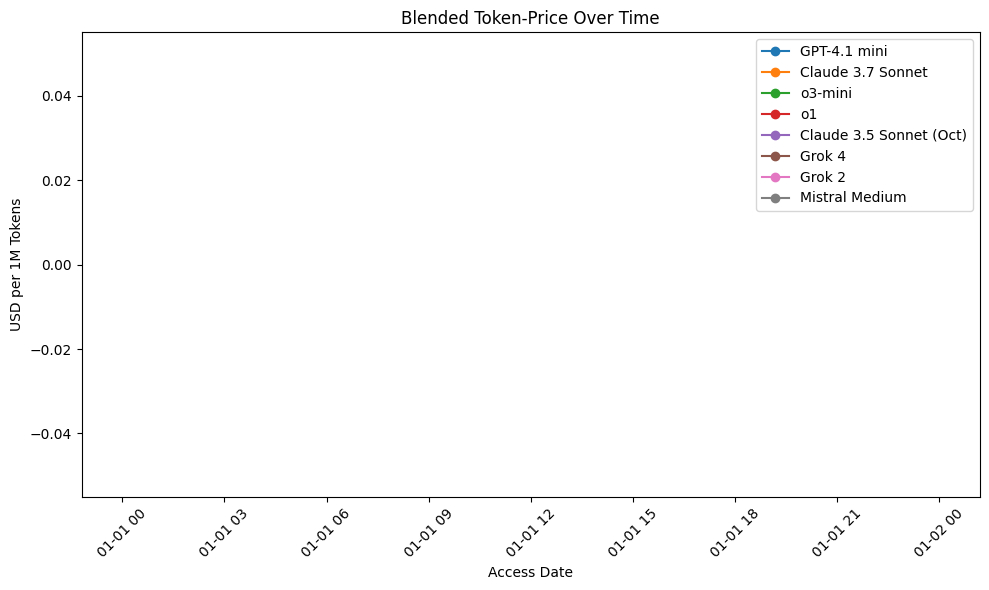

In [37]:
# 1) Parse the Access Date into real datetimes, drop invalid rows
df['Access Date'] = pd.to_datetime(df['Access Date'], format='%m/%d/%Y', errors='coerce')
df = df.dropna(subset=['Access Date'])

# 2) Clean up the Blended column (strip “$” and convert to float)
df['Blended'] = (
    df['Blended']
      .astype(str)
      .str.replace(r'[\$,]', '', regex=True)
      .astype(float)
)

# 3) Filter for the two models, sort by date
# models = ['Llama 2 Chat 7B', 'Gemma 7B', 'Llama 2 Chat 70B', 'Gemma 13B', 'Mistral Medium', 'Qwen2 72B', 'Qwen2.5 72B', "Qwen1.5 Chat 110B", "DeepSeek-V2", "GPT-4o mini"]

models = ["GPT-4.1 mini", "Claude 3.7 Sonnet", "o3-mini", "o1", "Claude 3.5 Sonnet (Oct)", "Grok 4", "Grok 2", "Mistral Medium"]
df_sub = (df[df['Model'].isin(models)]
            .sort_values('Access Date'))

# 4) Plot with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for m in models:
    d = df_sub[df_sub['Model']==m]
    plt.plot(d['Access Date'], d['Blended'], marker='o', label=m)

plt.title('Blended Token-Price Over Time')
plt.xlabel('Access Date')
plt.ylabel('USD per 1M Tokens')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.yscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


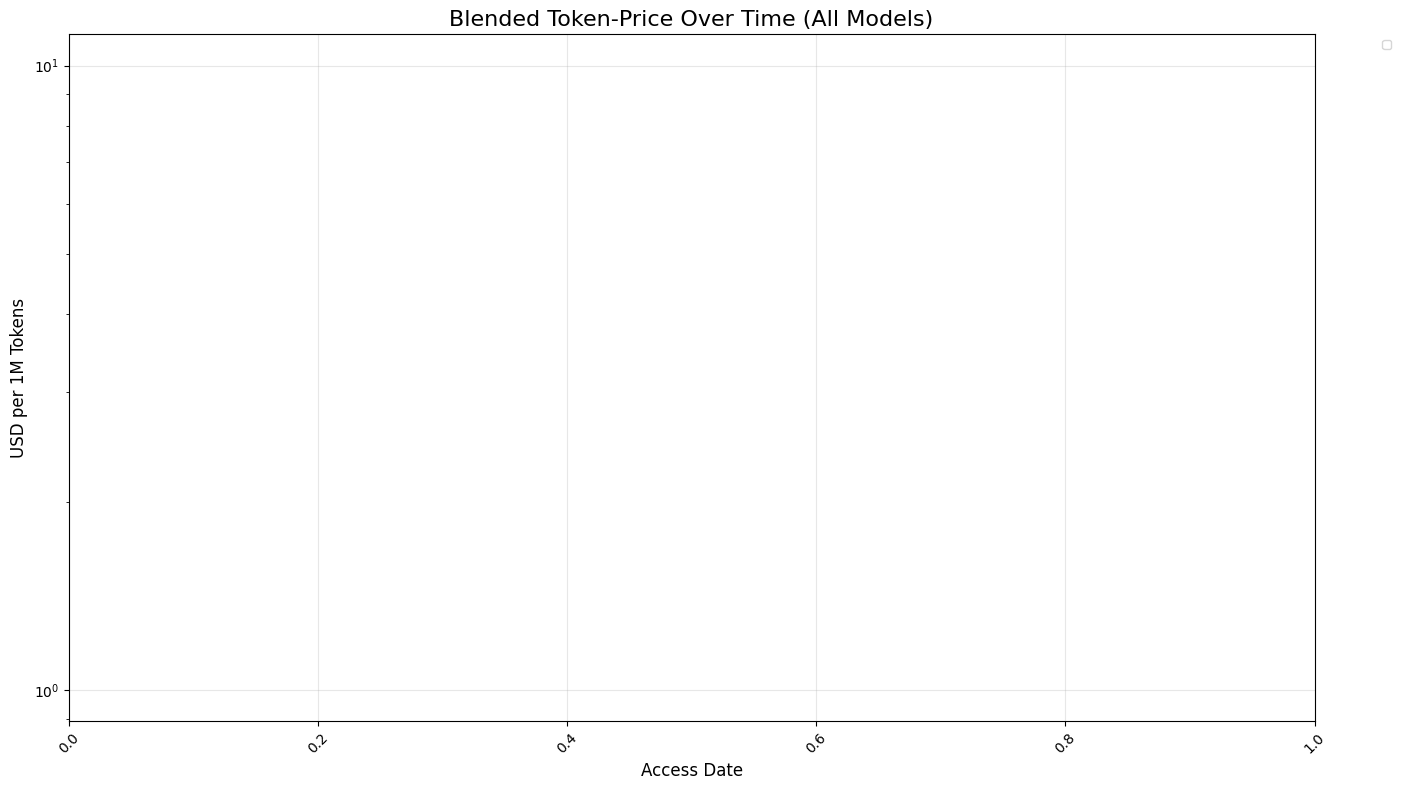


Summary:
Total models plotted: 0
Date range: NaT to NaT
Price range: $nan to $nan


In [11]:
# 1) Parse the Access Date into real datetimes, drop invalid rows
df['Access Date'] = pd.to_datetime(df['Access Date'], format='%m/%d/%Y', errors='coerce')
df = df.dropna(subset=['Access Date'])

# 2) Clean up the Blended column (strip "$" and convert to float)
df['Blended'] = (
    df['Blended']
      .astype(str)
      .str.replace(r'[\$,]', '', regex=True)
      .astype(float)
)

# 3) Get all unique models and sort by date
df_sub = df.sort_values('Access Date')

# 4) Plot with matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8))

# Get all unique models
all_models = df_sub['Model'].unique()

# Create a color map for better visualization with many models
colors = plt.cm.tab20(np.linspace(0, 1, len(all_models)))

# Plot each model
for i, model in enumerate(all_models):
    d = df_sub[df_sub['Model'] == model]
    if len(d) > 0:  # Only plot if there's data
        plt.plot(d['Access Date'], d['Blended'], 
                marker='o', 
                label=model,
                color=colors[i],
                alpha=0.7,
                markersize=4,
                linewidth=1)

plt.title('Blended Token-Price Over Time (All Models)', fontsize=16)
plt.xlabel('Access Date', fontsize=12)
plt.ylabel('USD per 1M Tokens', fontsize=12)

# Handle legend - since there are many models, you might want to adjust this
if len(all_models) <= 20:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
else:
    # For many models, you might want to skip the legend or show it differently
    print(f"Plotting {len(all_models)} models. Legend omitted due to space.")
    # plt.legend().set_visible(False)

plt.xticks(rotation=45)
plt.tight_layout()
plt.yscale('log')  # Using log scale since prices can vary widely
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print(f"\nSummary:")
print(f"Total models plotted: {len(all_models)}")
print(f"Date range: {df_sub['Access Date'].min()} to {df_sub['Access Date'].max()}")
print(f"Price range: ${df_sub['Blended'].min():.2f} to ${df_sub['Blended'].max():.2f}")

In [12]:
# Lower envelope analysis with exponential trend fitting
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from datetime import datetime

def find_lower_envelope_and_fit_trend(data, window_days=30, min_mmlu=50, max_mmlu=100, open_source_only=False, plot_results=True):
    """
    Find the lower envelope of price data and fit an exponential trend line
    
    Parameters:
    data: DataFrame with price and date data
    window_days: Number of days for rolling minimum window
    min_mmlu: Minimum MMLU score filter
    max_mmlu: Maximum MMLU score filter
    open_source_only: Whether to analyze only open source models
    plot_results: Whether to create visualizations
    """
    
    # Filter by MMLU range
    filtered_data = data[(data[mmlu_col] >= min_mmlu) & (data[mmlu_col] <= max_mmlu)].copy()
    
    if len(filtered_data) == 0:
        print(f"No data found for MMLU range {min_mmlu}-{max_mmlu}")
        return None, None
    
    # Parse dates and clean prices
    filtered_data['Access Date'] = pd.to_datetime(filtered_data['Access Date'], format='%m/%d/%Y', errors='coerce')
    filtered_data = filtered_data.dropna(subset=['Access Date'])
    
    filtered_data['Blended'] = (
        filtered_data['Blended']
        .astype(str)
        .str.replace(r'[\$,]', '', regex=True)
        .replace('nan', np.nan)
        .astype(float)
    )
    filtered_data = filtered_data.dropna(subset=['Blended'])
    
    # Add license information
    filtered_data['Is_Open_Source'] = filtered_data['License'].str.contains('Open', case=False, na=False)
    
    # Filter for open source if requested
    if open_source_only:
        filtered_data = filtered_data[filtered_data['Is_Open_Source']]
        if len(filtered_data) == 0:
            print("No open source models found in the specified range!")
            return None, None
    
    # Remove zero or negative prices for log fitting
    filtered_data = filtered_data[filtered_data['Blended'] > 0]
    
    if len(filtered_data) < 5:
        print(f"Not enough data points ({len(filtered_data)}) for trend analysis")
        return None, None
    
    # Sort by date
    filtered_data = filtered_data.sort_values('Access Date').reset_index(drop=True)
    
    # Convert dates to numeric (days since earliest date)
    min_date = filtered_data['Access Date'].min()
    filtered_data['days_since_start'] = (filtered_data['Access Date'] - min_date).dt.days
    
    # Find lower envelope using rolling minimum
    # Group by time windows and find minimum price in each window
    max_days = filtered_data['days_since_start'].max()
    day_range = np.arange(0, max_days + window_days, window_days)
    
    envelope_days = []
    envelope_prices = []
    
    for i in range(len(day_range) - 1):
        start_day = day_range[i]
        end_day = day_range[i + 1]
        
        window_data = filtered_data[
            (filtered_data['days_since_start'] >= start_day) & 
            (filtered_data['days_since_start'] < end_day)
        ]
        
        if len(window_data) > 0:
            min_price = window_data['Blended'].min()
            mid_day = (start_day + end_day) / 2
            envelope_days.append(mid_day)
            envelope_prices.append(min_price)
    
    if len(envelope_days) < 3:
        print("Not enough envelope points for trend fitting")
        return None, None
    
    envelope_days = np.array(envelope_days)
    envelope_prices = np.array(envelope_prices)
    
    # Define exponential decay function: P(t) = A * exp(-k*t) + C
    def exponential_decay(t, A, k, C):
        return A * np.exp(-k * t) + C
    
    # Define exponential growth function: P(t) = A * exp(k*t) + C  
    def exponential_growth(t, A, k, C):
        return A * np.exp(k * t) + C
    
    # Try both decay and growth models
    try:
        # Initial guess for parameters
        p0_decay = [envelope_prices[0], 0.01, min(envelope_prices)]
        p0_growth = [min(envelope_prices), -0.01, 0]
        
        # Fit both models
        popt_decay, pcov_decay = curve_fit(exponential_decay, envelope_days, envelope_prices, 
                                          p0=p0_decay, maxfev=2000)
        popt_growth, pcov_growth = curve_fit(exponential_growth, envelope_days, envelope_prices, 
                                           p0=p0_growth, maxfev=2000)
        
        # Calculate R-squared for both fits
        y_pred_decay = exponential_decay(envelope_days, *popt_decay)
        y_pred_growth = exponential_growth(envelope_days, *popt_growth)
        
        ss_res_decay = np.sum((envelope_prices - y_pred_decay) ** 2)
        ss_res_growth = np.sum((envelope_prices - y_pred_growth) ** 2)
        ss_tot = np.sum((envelope_prices - np.mean(envelope_prices)) ** 2)
        
        r2_decay = 1 - (ss_res_decay / ss_tot)
        r2_growth = 1 - (ss_res_growth / ss_tot)
        
        # Choose the better fit
        if r2_decay > r2_growth:
            best_fit = 'decay'
            popt_best = popt_decay
            r2_best = r2_decay
            fit_func = exponential_decay
            trend_direction = "decreasing"
        else:
            best_fit = 'growth'
            popt_best = popt_growth
            r2_best = r2_growth
            fit_func = exponential_growth
            trend_direction = "increasing" if popt_growth[1] > 0 else "decreasing"
        
    except Exception as e:
        print(f"Error fitting exponential trend: {e}")
        return envelope_days, envelope_prices
    
    if plot_results:
        # Create the plot
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Plot all data points
        if not open_source_only:
            proprietary_data = filtered_data[~filtered_data['Is_Open_Source']]
            if len(proprietary_data) > 0:
                ax.scatter(proprietary_data['Access Date'], proprietary_data['Blended'], 
                          alpha=0.4, s=40, marker='o', 
                          c='lightcoral', label='Proprietary', edgecolors='darkred', linewidth=0.3)
            
            os_data = filtered_data[filtered_data['Is_Open_Source']]
            if len(os_data) > 0:
                ax.scatter(os_data['Access Date'], os_data['Blended'], 
                          alpha=0.6, s=60, marker='^', 
                          c='lightgreen', label='Open Source', edgecolors='darkgreen', linewidth=0.3)
        else:
            ax.scatter(filtered_data['Access Date'], filtered_data['Blended'], 
                      alpha=0.6, s=60, marker='^', 
                      c='lightgreen', label='Open Source', edgecolors='darkgreen', linewidth=0.3)
        
        # Plot lower envelope
        envelope_dates = [min_date + pd.Timedelta(days=d) for d in envelope_days]
        ax.plot(envelope_dates, envelope_prices, 'ro-', linewidth=2, markersize=6, 
                label=f'Lower Envelope (window={window_days}d)', alpha=0.8)
        
        # Plot exponential trend line
        trend_days = np.linspace(0, max_days, 100)
        trend_prices = fit_func(trend_days, *popt_best)
        trend_dates = [min_date + pd.Timedelta(days=d) for d in trend_days]
        
        ax.plot(trend_dates, trend_prices, 'b--', linewidth=3, 
                label=f'Exponential Trend (R²={r2_best:.3f})', alpha=0.8)
        
        # Formatting
        title_prefix = "Open Source " if open_source_only else ""
        ax.set_title(f'{title_prefix}Price Lower Envelope & Exponential Trend\n(MMLU: {min_mmlu}-{max_mmlu})', 
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Price (USD per 1M Tokens)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print trend analysis
        print(f"\n=== Lower Envelope & Trend Analysis ===")
        print(f"Data points: {len(filtered_data)}")
        print(f"Envelope points: {len(envelope_days)}")
        print(f"Best fit model: {best_fit}")
        print(f"R-squared: {r2_best:.4f}")
        print(f"Trend direction: {trend_direction}")
        
        if best_fit == 'decay':
            A, k, C = popt_best
            print(f"Exponential decay: P(t) = {A:.4f} * exp(-{k:.6f}*t) + {C:.4f}")
            if k > 0:
                half_life = np.log(2) / k
                print(f"Half-life: {half_life:.1f} days")
        else:
            A, k, C = popt_best
            print(f"Exponential trend: P(t) = {A:.4f} * exp({k:.6f}*t) + {C:.4f}")
            if k != 0:
                doubling_time = np.log(2) / abs(k)
                print(f"Doubling/halving time: {doubling_time:.1f} days")
    
    return envelope_days, envelope_prices, popt_best, r2_best


In [13]:
# Demonstrate the lower envelope analysis
print("=== Lower Envelope & Exponential Trend Analysis ===")

# Example 1: All models in high MMLU range
print("\n1. High performing models (70+ MMLU-Pro score) - Lower Envelope Analysis:")
find_lower_envelope_and_fit_trend(merged_all, window_days=45, min_mmlu=70, max_mmlu=100, open_source_only=False)

# Example 2: Open source models only
print("\n2. Open source models only (50+ MMLU-Pro score) - Lower Envelope Analysis:")
find_lower_envelope_and_fit_trend(merged_all, window_days=30, min_mmlu=50, max_mmlu=100, open_source_only=True)

# Example 3: All models in broader range to see overall trend
print("\n3. All models (broader MMLU range) - Lower Envelope Analysis:")
find_lower_envelope_and_fit_trend(merged_all, window_days=60, min_mmlu=40, max_mmlu=100, open_source_only=False)


=== Lower Envelope & Exponential Trend Analysis ===

1. High performing models (70+ MMLU-Pro score) - Lower Envelope Analysis:
Not enough data points (0) for trend analysis

2. Open source models only (50+ MMLU-Pro score) - Lower Envelope Analysis:
No open source models found in the specified range!

3. All models (broader MMLU range) - Lower Envelope Analysis:
Not enough data points (0) for trend analysis


(None, None)